# Lab exercise: Real NVP

In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import itertools
import random
import math
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

%matplotlib inline

In [2]:
# samples1-2 shape must be (n samples, 2)
def plot_samples(samples1, samples2=None):
    fig, ax = plt.subplots()

    ax.scatter(samples1[:,0], samples1[:,1], marker="x", color="blue")
    if samples2 is not None:
        ax.scatter(samples2[:,0], samples2[:,1], marker="x", color="red")

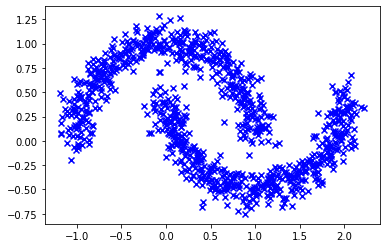

In [3]:
import sklearn.datasets

target_samples, target_classes = sklearn.datasets.make_moons(1000, noise=0.1)
target_samples = torch.from_numpy(target_samples).float()

plot_samples(target_samples)

In [4]:
class RealNVPLayer(nn.Module):
    def __init__(self, size, reverse=False):
        super().__init__()
        
        self.mask = torch.zeros(size, requires_grad=False)
        mid = int(size / 2)
        if reverse:
            self.mask[mid:] = 1.
        else:
            self.mask[:mid] = 1.
        
        ## the two operations
        self.scale = nn.Sequential(
            nn.Linear(size, 10),
            nn.Tanh(),
            nn.Linear(10, size),
        )
        self.transpose = nn.Sequential(
            nn.Linear(size, 10),
            nn.Tanh(),
            nn.Linear(10, size),
        )
        
    # project from the latent space to the observed space,
    # i.e. x = g(z)
    def forward(self, z):
        # you will need this!
        n_mask = 1. - self.mask
        z_masked = z * self.mask
        
        x = self.mask * z + n_mask * (z * torch.exp(self.scale(z_masked)) + self.transpose(z_masked))
        
        return x

    # project from the observed space to the latent space,
    # this function also return the log det jacobian of this inv function
    def inv(self, x):
        # you will need this!
        n_mask = 1. - self.mask
        x_masked = x * self.mask
        
        # BEGIN TODO
        z = self.mask * x + n_mask * ((x - self.transpose(x_masked)) * torch.exp(-self.scale(x_masked)))
        log_det_jacobian = (n_mask * (-self.scale(x_masked))).sum(1)
        # END TODO
        
        return z, log_det_jacobian

In [5]:
# Test!
layer = RealNVPLayer(2, reverse=False)

with torch.no_grad():
    x = torch.rand(1, 2)
    z, _ = layer.inv(x)
    xx = layer(z)

    print("In the 3 vectors below, the first element must be equal")
    print("This two vectors should be equal:")
    print(x)
    print(xx)
    print("This vector should be different to the two above")
    print(z)
print()

layer = RealNVPLayer(2, reverse=True)

with torch.no_grad():
    x = torch.rand(1, 2)
    z, _ = layer.inv(x)
    xx = layer(z)

    print("In the 3 vectors below, the second element must be equal")
    print("This two vectors should be equal:")
    print(x)
    print(xx)
    print("This vector should be different to the two above")
    print(z)

In the 3 vectors below, the first element must be equal
This two vectors should be equal:
tensor([[0.7365, 0.9203]])
tensor([[0.7365, 0.9203]])
This vector should be different to the two above
tensor([[0.7365, 0.4649]])

In the 3 vectors below, the second element must be equal
This two vectors should be equal:
tensor([[0.2423, 0.6708]])
tensor([[0.2423, 0.6708]])
This vector should be different to the two above
tensor([[0.1688, 0.6708]])


In [6]:
class RealNVP(nn.Module):
    def __init__(self, size, n_layers):
        super().__init__()
        
        self.prior = torch.distributions.normal.Normal(torch.zeros(2), torch.ones(2))
        
        self.layers = nn.ModuleList(
                            RealNVPLayer(size, i % 2 == 0)
                            for i in range(n_layers)
        )
    
    def forward(self, z):
        x = z
        for i in range(len(self.layers)):
            x = self.layers[i](x)
        return x
    
    def inv(self, x):
        log_det_jacobian = 0.
        z = x
        for i in reversed(range(len(self.layers))):
            z, j = self.layers[i].inv(z)
            # remember here, we just have to sum all log det jacobians!
            log_det_jacobian = log_det_jacobian + j
        return z, log_det_jacobian

    
    def sample(self, n_samples):
        z = self.prior.sample((n_samples,))
        x = self(z)
        return x

    
    def log_prior(self, z):
        x, det = self.inv(z)
        ret = self.prior.log_prob(x).sum(1) + det
        
        return ret

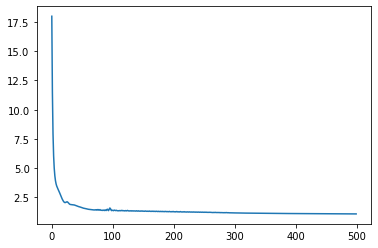

In [7]:
trained_distrib = RealNVP(2, 50)
optimizer = torch.optim.Adam(trained_distrib.parameters(), lr=1e-3)

batch_size = 1000
losses = list()
for _ in range(500):
    for i in range(0, target_samples.shape[0], batch_size):
        batch = target_samples[i:i+batch_size]
        optimizer.zero_grad()

        loss = -trained_distrib.log_prior(batch).mean()
        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(trained_distrib.parameters(), 5)
        optimizer.step()
    
plt.plot(np.arange(len(losses)), losses)

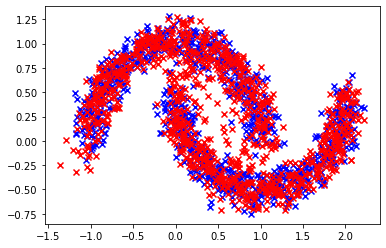

In [8]:
# sample from the model
with torch.no_grad():
    samples = trained_distrib.sample(1000)
    plot_samples(target_samples, samples)

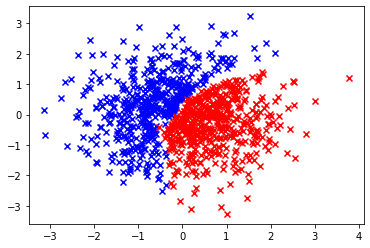

In [9]:
# print the latent space corresponding to each half moon in a different color
with torch.no_grad():
    source_sample1, _ = trained_distrib.inv(target_samples[target_classes == 0])
    source_sample2, _ = trained_distrib.inv(target_samples[target_classes == 1])
    plot_samples(source_sample1, source_sample2)